# Merjenje pospeškov v biomehaniki - višina skoka in test "Vstani in pojdi"

## Potrebne knjižnice in funkcije
Vsebino spodnje celice je potrebno izvesti le enkrat. Ker ves proces poteka v spletnem brskalniku vaše naprave, lahko ta korak traja nekaj časa.

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import sys,os
import matplotlib.pyplot as plt
%pip install -q ipympl
%matplotlib widget

def Raw_Filtered_Plot(t,y,fy,measurement='Measurement',xlabel='x',ylabel='y',legend='True'):
    '''Plot Raw and Filtered data over time'''
    fig = plt.figure()
    plt.plot(t,y,label=f'Neobdelani podatki')# LDJ = {ldj:.0f}')
    plt.plot(t,fy,label=f'Filtrirani podatki')# LDJ = {ldjf:.0f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(measurement)
    if legend: plt.legend(loc='upper right')
    plt.show()

def AnalyzeSignal(d,ydataNo,order=8,CNr=0.1,Start=0,Interval=0,plot=True,legend='True'):
    '''Get Raw and Filtered data. Using Lowpass Butterworth filter with order=order and Cnr=f_crit/f_Nyquist'''
    
    # Get sampling frequency over the whole interval (cutting off cut first and last points)
    cut = 0
    t, y = [d.iloc[:,col][cut:-(cut+1)] for col in (0,ydataNo)]
    dtlist = t.diff()[1:]
    fslist = 1/dtlist # Sampling frequency
    fs, sfs = np.average(fslist),np.std(fslist)
    sampling = f', Vzorčenje: $\\nu$ = {fs:.0f} Hz, $\sigma_\\nu =$ {sfs:.0f} Hz'
    
    # Filter and plot interval given in seconds
    if Interval == 0:
        Intervals = len(d)-int(Start*fs)
    else:
        Intervals = int(Interval*fs)
    Starts = int(Start*fs)
    t, y = [d.iloc[:,col][Starts:Starts+Intervals] for col in (0,ydataNo)]
    b, a = signal.butter(order, CNr * (0.5*fs), fs = fs) # Lowpass Butterworth filter with order=order and Cnr=f_crit/f_Nyquist
    fy = signal.filtfilt(b, a, y) # Apply filter forward and backward to a signal
    Raw_Filtered_Plot(t,y,fy,
                      measurement,
                      xlabel=d.columns[0]+sampling,
                      ylabel=d.columns[ydataNo],
                      legend=legend)
    return #t, y, fy

## Meritve

### PhyPhox
[PhyPhox](https://phyphox.org/) je odprtokodna aplikacija za mobilne naprave. Z njo lahko zajemamo podatke senzorjev, npr. vztrajnostnih merilnih enot ([angl. Inertial Measurement Unit - IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)). IMU v naših pametnih telefonih ali tablicah bomo uporabili za zajem pospeškov (s pospeškometri) in kotnih hitrosti (z giroskopi) v biomehanskih meritvah.


#### Spoznavanje z aplikacijo:
> 0. Na vašo mobilno napravo namestite aplikacijo [PhyPhox](https://phyphox.org/)
> 1. Izberite npr. *Raw Sensors/Acceleration with g* - zajemanje podatkov pospeškometrov
> 2. Za začetek meritve pritisnite gumb "Play" (&#9658;) in spremljajte nastajajoče grafe
> 3. Iz podatkov razberite orientacijo koodinatega sistema na vaši napravi (težni pospešek $g \approx 10$ m/s$^2$ kaže navpično navzdol)

![Koordinatni sistem PhyPhox](fig/coordinate_system.jpg "Koordinatni sistem PhyPhox")

### Filtriranje signala

Včasih je koristno merske podatke filtrirati. V biomehaniki pogosto želimo iz merskih podatkov izločiti nihanja signala na časovni skali, ki je manjša od najhitrejšega pričakovanega odziva telesa (odziv mišično-skeletnega sistema na zunanje dražljaje je približno 0,2 s). Na izmerjenih podatkih boste spodaj lahko preizkusili nizkopasovni [Butterworthov filter](https://en.wikipedia.org/wiki/Butterworth_filter), ki prepušča nizke frekvence signala, višje pa oslabi. Parametra filtra v spodnji kodi sta:
- "order", ki predstavlja red filtra. Višji, ko je red, bolj "ostro" odreže visoke frekvence. Vrednost parametra lahko pustite kar na 5,
- "CNr", ki je razmerje med kritično frekvenco in polovično frekvenco vzorčenja (Nykvistova frekvenca). Pri kritični frekvenci jakost filtriranega signala pade na $1/\sqrt{2}$ nefiltrirane vrednosti. Vrednost parametra je lahko v intervalu (0,1). Poskusite npr. vrednosti CNr = 0.01 in CNr = 0.1.

## 1. naloga: Višina skoka
Višino skoka lahko izračunamo iz časa skoka. Iz enačbe za navpični met namreč za višino skoka lahko zapišemo
$$h = \frac{g \left(\frac{t}{2}\right)^2}{2} = \frac{g\: t^2}{8} \: ,$$
kjer je $t$ čas, ko skakalec ni v stiku s podlago (gibanje navzgor in gibanje navzdol v približku navpičnega meta trajata enako dolgo, torej vsako $\frac{t}{2}$), $g$ pa je težni pospešek.

Z mobilnim telefonom in aplikacijo Phyphox izmerite pospeške med skokom. Iz analize pospeškov poskusite izmeriti čas skoka ($t$) in iz tega višino skoka ($h$). Primerjajte rezultat s preprosto meritvijo z merskim trakom oziroma vašo oceno višine skoka.

**Primer protokola meritve** z aplikacijo [PhyPhox](https://phyphox.org/) z mobilnikom in prenosnikom (lahko tudi tabličnim računalnikom ali drugim telefonom), na katerem nadziramo meritev. Dve napravi nista nujni, je pa izvajanje tako bolj kontrolirano. Uporabljeni napravi morata biti v istem omrežju (uredite si npr. mobile hotspot ali uporabite Eduroam, ki je v laboratoriju):
>#### Pred meritvijo (v aplikaciji PhyPhox)
>1. Izberite način zajema, npr. *Acceleration with g*.
>2. Izberite *Allow remote access* in Phybox vam ponudi HTTP naslov, ki ga odprete v prenosniku.
>3. Mobilno napravo namestite za meritev. Izberite primeren položaj (čim bližje težišču telesa) in orientacijo naprave.

>#### Meritev (v spletnem brskalniku prenosnika, kjer odprete ponujeni HTTP naslov ali v PhyPhox aplikaciji)
>1. Zaženite in **izvedite meritev** 
>2. Meritev lahko izvedete večkrat, da dobite občutek za primerno postavitev naprave, izvedbo ipd. Pred ponovno meritvijo lahko izberete *Clear recorded data*.
>3. Izberite *Export data* in shranite podatke, npr. kot *CSV (Comma, decimal point)*. 

>#### Obdelava podatkov
Shranjene podatke lahko uvozite, pregledate in obdelate v tej interaktivni beležnici (glej spodaj).

### Analiza merskih podatkov

In [2]:
measurement = 'data/Raw Data_skok.csv'
print(f'Berem datoteko: \"{measurement}\"')
pd.read_csv(measurement)

Berem datoteko: "data/Raw Data_skok.csv"


,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.019190,0.801596,9.647861,-0.717847,9.707681
1,0.021723,0.808774,9.643075,-0.681954,9.700932
2,0.024256,0.818345,9.643075,-0.646062,9.699277
3,0.026788,0.823131,9.657433,-0.629312,9.712857
4,0.029321,0.820738,9.667004,-0.619741,9.721556
...,...,...,...,...,...
6400,16.228384,-0.186640,9.681360,-0.933201,9.728023
6401,16.230917,-0.193819,9.681360,-0.926022,9.727478
6402,16.233450,-0.215354,9.686146,-0.928415,9.732921
6403,16.235982,-0.222533,9.678967,-0.937986,9.726857


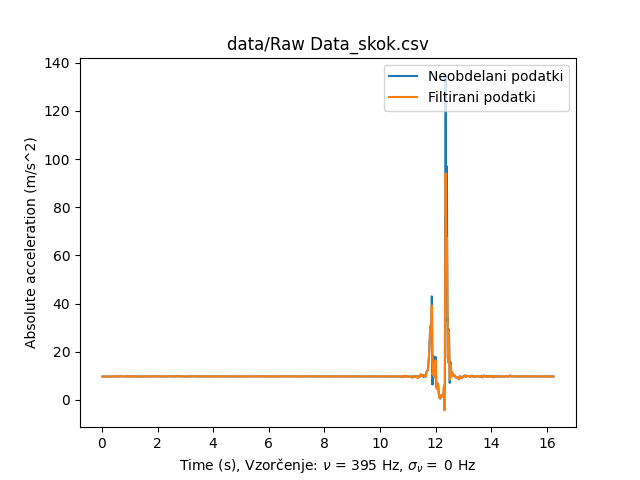

In [3]:
# Izriši filtrirane in nefiltrirane podatke 

# Izberi podatke in interval izrisa
ydataNo = 4 # Zaporedna številka stolpca za analizo
Start = 0 # Začetek prikazanega intervala [s]
Interval = 0  # Dolžina prikazanega intervala [s]. Izberi 0 za celoten interval.

# Filtriranje signala z Butterworthovim filtrom (odreže visoke frekvence):
order = 5 # Red filtra. Lahko pustite kar 5.
CNr = 0.1 #  Poskusite 0.01 and 0.1. Izbira je možna v intervalu (0,1). CNr predstavlja f_crit/f_Nyquist filtra. 

AnalyzeSignal(pd.read_csv(measurement),ydataNo,order,CNr, Start,Interval)

### Izračun višine skoka

Iz analize pospeškov poskusite izmeriti čas skoka ($t$) in iz tega višino skoka po enačbi $h=g t^2/8$. Primerjajte dobljeni rezultat s preprosto meritvijo z merskim trakom oziroma vašo oceno višine skoka.

In [4]:
to = 11.88 # Čas odskoka
td = 12.32 # Čas doskoka

In [5]:
t = td - to
g = 9.81
h = g * t**2 / 8
print(f'Višina skoka: h = {h*100:.1f} cm')

Višina skoka: h = 23.7 cm


## 2. naloga: Časovno merjeni test vstani in pojdi
Časovno merjeni test vstani in pojdi (angl. Timed Up and Go Test – TUG) je klinična izvedbena mera funkcije spodnjih udov, premičnosti in ocene tveganja za pojavnost padcev. Zaradi svoje preproste in hitre izvedljivosti, meri se le čas, ki ga preiskovanec potrebuje za izvedbo, je mera zelo široko uporabna (glejte npr. [Jakovljević, 2013](https://physio.si/wp-content/uploads/2021/07/6.-Casovno-merjeni-test_2013_No1_p38-47.pdf)). S senzorji pametnega telefona pa lahko izvedemo t.i. instrumentalizirani TUG (glejte npr. [Mellone et al., 2012](https://doi.org/10.1016/j.gaitpost.2012.02.006)).

Z mobilnim telefonom in aplikacijo Phyphox izmerite kotno hitrost in/ali pospešek med Časovno merjenim testom vstani in pojdi (za protokol izvedbe testa glejte npr. [ocenjevalni list CDC](https://www.cdc.gov/steadi/pdf/TUG_test-print.pdf)). Iz analize podatkov izmerite čas izvedbe in ga primerjajte z rezultatom izmerjenim z uro. Nato poskusite razpoznati različne faze testa, npr.:
![Faze TUG](fig/TUG_faze.png "Faze TUG")

Ali lahko iz zajetih podatkov razberete tudi posamezne korake? Kaj bi še lahko ocenili iz pridobljenih podatkov? Glejte npr. meritve anteriorno-posteriornega pospeška iz [Mellone et al., 2012](https://doi.org/10.1016/j.gaitpost.2012.02.006):
![Anteriorno-posteriorni pospešek pri TUG](fig/TUG_APacc.png "Anteriorno-posteriorni pospešek pri TUG")